# GUIDE FOR BINARY CLASSIFICATION PROBLEMS

In this notebook I will solve a classification problem with two targets. **The goal for this notebook is to give a idea of the steps we need to follow to solve a binary classification problem** and to show some interesting techniques to do it.

The problem we will be solving is this:  [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn)

In this notebook I basically simplify the great work done in the following notebook:
* [Telecom Customer Churn Prediction](https://www.kaggle.com/pavanraj159/telecom-customer-churn-prediction/notebook)



Any comments or suggestions are very welcome.

Ok, we begin by importing a set of packages we'll be needing:

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Importing the data:

In [4]:
df = pd.read_csv('/home/pablo/Escritorio/Postgrado_UB/Problemas Kaggle/Plantillas/CLASIFICACIÓN BINARIA/datos/raw_data_telco.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## STEP 0 : EXPLORATORY DATA ANALYSIS (EDA)

First of all, let's take a look a our data.

In [5]:
print('ROWS: ', df.shape[0])
print('COLUMNS: ', df.shape[1])
print('nombre columnas: ', df.columns.tolist())
print('valores únicos por columna: ', df.nunique())
print('missing values: ', df.isnull().sum().values)
print('tipo de columnas: ',df.dtypes)

data_cat = df.select_dtypes('object').columns.tolist()
for i in data_cat:
    print(df[i].value_counts())

ROWS:  7043
COLUMNS:  21
nombre columnas:  ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
valores únicos por columna:  customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64
missing values:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
tipo 

Quick look at the numbers of the target variable **'Churn'**

In [28]:
df['Churn'].value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

We can already see some little transformations we can make, so before we do any exploratory analysis, let's get them out of the way.
Apparently we don't have any missing data, but there are some columns that are not of the right type. **'SeniorCitizen'** should be an 'object' and **'TotalCharges'** a 'float'. Let's apply this and other transformations that seem appropriate:

In [6]:
df['TotalCharges']=df['TotalCharges'].replace(' ',np.nan)
df['TotalCharges']=df['TotalCharges'].astype(float)
df['TotalCharges']=df['TotalCharges'].fillna(df['TotalCharges'].mean())

nointernet_cols = ['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
for i in nointernet_cols:
    df[i]=df[i].replace('No internet service','No')

df['MultipleLines']=df['MultipleLines'].replace('No phone service','No')

df["SeniorCitizen"] = df["SeniorCitizen"].replace({1:"Yes",0:"No"})

#We will use the numeric variable tenure for the model, but in order to have some insights we create this segment.
def tenure_tramo(df):
    if df['tenure'] <=12:
        return 'Tenure_0-12'
    elif (df['tenure']>12) & (df['tenure'] <= 24) :
        return 'Tenure_12-24'
    elif (df['tenure'] > 24) & (df['tenure'] <= 48) :
        return 'Tenure_24-48'
    elif (df['tenure'] > 48) & (df['tenure'] <= 60) :
        return 'Tenure_48-60'
    elif df['tenure'] > 60 :
        return 'Tenure_gt_60'
    
df['tenure_group'] = df.apply(lambda df:tenure_tramo(df),axis = 1)

Let's take a look at how **categorical variables** plot when we compare churn and non-churn customers:

In [9]:
from plotly.offline import plot 
import plotly.graph_objs as go


#piechart function
def piecharts (columna):
    trace_churn = go.Pie(labels = churn[columna].value_counts().keys().tolist() ,
               values = churn[columna].value_counts().values.tolist() ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  3.6)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               domain  = dict(x = [0,.48]),
               name= "Churn customers",
               hole = .7
              )

    trace_nochurn = go.Pie(labels = no_churn[columna].value_counts().keys().tolist() ,
               values = no_churn[columna].value_counts().values.tolist() ,
               marker = dict(colors =  [ 'royalblue' ,'lime'],
                             line = dict(color = "white",
                                         width =  3.6)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               domain  = dict(x = [0.52,1]),
               name= "Non Churn customers",
               hole = .7
              )
                             
    layout = go.Layout(dict(title = columna + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 20),
                                                showarrow = False,
                                                x = .17, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 20),
                                                showarrow = False,
                                                x = .85,y = .5
                                               )
                                          ]
                           )
                      )

    data = [trace_churn,trace_nochurn]
    fig = go.Figure(data = data,layout = layout)
    plot(fig)

In [ ]:
churn=df[df['Churn']=='Yes']
no_churn=df[df['Churn']=='No']

In [ ]:
data_cat = df.select_dtypes('object').columns.tolist()
data_cat = [x for x in data_cat if x not in 'customerID']

In [12]:
for i in data_cat:
    piecharts(i)

Let's take a look at how **numerical variables** plot when we compare churn and non-churn customers:

In [16]:
#plot numerical variables
def HISTO (columna):
    trace_churn = go.Histogram(x = churn[columna] ,
               histnorm = "percent",
               marker = dict(line = dict(color = "black",
                                         width =  0.6)
                            ),
               name= "Churn customers",
               opacity = .9
              )

    trace_nochurn = go.Histogram(x = no_churn[columna] ,
               histnorm = "percent",
               marker = dict(line = dict(color = "black",
                                         width =  0.6)
                            ),
               name= "Non churn customers",
               opacity = .9
              )
                             
    layout = go.Layout(dict(title = columna + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = columna,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )

    data = [trace_churn,trace_nochurn]
    fig = go.Figure(data = data,layout = layout)
    plot(fig)

In [17]:
data_num =  df.select_dtypes(['int64','float64']).columns.tolist()
for i in data_num:
    HISTO(i)

Let's get an idea of what the **distribution of our numerical variables** looks like:

In [19]:
df[data_num].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
TotalCharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80


## STEP 1 : DATA PREPROCESSING

In [20]:
df=df.drop('customerID',axis=1)

target_col=['Churn']
 
data_num =  df.select_dtypes(['int64','float64']).columns.tolist()
data_cat = df.select_dtypes(['object']).columns.tolist()

* **First transformation:** Normalizing numeric variables

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

std=StandardScaler()
scaled=std.fit_transform(df[data_num])
scaled=pd.DataFrame(scaled,columns=data_num)

df_original=df.copy()
df=df.drop(data_num,axis=1)

df=df.merge(scaled,left_index=True,right_index=True,how='left')

* **Second transformation:** Encoding categorical variables

In [ ]:
le=LabelEncoder()
for i in data_cat:
    df[i]=le.fit_transform(df[i])   
                                                                    
df=pd.get_dummies(data=df,columns=data_cat,drop_first=True)

In [22]:
df['Churn']=df['Churn_1']
df=df.drop('Churn_1',axis=1)

## STEP 2 : MODELLING

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from yellowbrick.classifier import DiscriminationThreshold

In [24]:
train,test=train_test_split(df,test_size=.25, random_state =111)

cols    = [i for i in df.columns if i not in target_col]

train_X = train[cols]
train_Y = train[target_col]
test_X  = test[cols]
test_Y  = test[target_col]

Since we've seen that the number of customers that churned (1.869) is significantly higher than the number of non-churned (5.174) . **We are going to use smote to oversample the churned class** 

In [25]:
from imblearn.over_sampling import SMOTE

os_smote = SMOTE(random_state = 0)
train_X_smote,train_Y_smote = os_smote.fit_sample(train_X,train_Y)
train_X_smote = pd.DataFrame(data = train_X_smote,columns=cols)
train_Y_smote = pd.DataFrame(data = train_Y_smote,columns=target_col)

### Models

In [29]:
from sklearn.metrics import cohen_kappa_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [35]:
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

dt_classifier = DecisionTreeClassifier()

knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

rfc   = RandomForestClassifier()

gnb = GaussianNB(priors=None)

svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=None, shrinking=True,
               tol=0.001, verbose=False)

svc_rbf  = SVC(C=1.0, kernel='rbf', 
               degree= 3, gamma=1.0, 
               coef0=0.0, shrinking=True,
               probability=True,tol=0.001,
               cache_size=200, class_weight=None,
               verbose=False,max_iter= -1,
               random_state=None)

lgbm_c = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.5, max_depth=7, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
                        n_jobs=-1, num_leaves=500, objective='binary', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)

xgc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, missing=None, n_estimators=100,
                    n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)

### Model performance metrics

In [ ]:
from plotly.offline import plot
import plotly.figure_factory as ff

def model_report(model,training_x,testing_x,training_y,testing_y,name) :
    model.fit(training_x,training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(logit,train_X_smote,test_X,train_Y_smote,test_Y,
                      "Logistic Regression")

model4 = model_report(dt_classifier,train_X_smote,test_X,train_Y_smote,test_Y,
                      "Decision Tree")

model5 = model_report(knn,train_X_smote,test_X,train_Y_smote,test_Y,
                      "KNN Classifier")

model6 = model_report(rfc,train_X_smote,test_X,train_Y_smote,test_Y,
                      "Random Forest Classifier")

model7 = model_report(gnb,train_X_smote,test_X,train_Y_smote,test_Y,
                      "Naive Bayes")

model8 = model_report(svc_lin,train_X_smote,test_X,train_Y_smote,test_Y,
                      "SVM Classifier Linear")

model9 = model_report(svc_rbf,train_X_smote,test_X,train_Y_smote,test_Y,
                      "SVM Classifier RBF")

model10 = model_report(lgbm_c,train_X_smote,test_X,train_Y_smote,test_Y,
                      "LGBM Classifier")

model11 = model_report(xgc,train_X_smote,test_X,train_Y_smote,test_Y,
                      "XGBoost Classifier")

#concat all models
model_performances = pd.concat([model1,
                                model4,model5,model6,
                                model7,model8,model9,
                                model10,model11],axis = 0).reset_index()

model_performances = model_performances.drop(columns = "index",axis =1)

table  = ff.create_table(np.round(model_performances,4))
plt.plot(table)

### Compare model metrics

In [41]:
def output_tracer(metric,color) :
    tracer = go.Bar(y = model_performances["Model"] ,
                    x = model_performances[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer

layout = go.Layout(dict(title = "Model performances",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "metric",
                                     zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(l = 250),
                        height = 780
                       )
                  )


trace1  = output_tracer("Accuracy_score","#6699FF")
trace2  = output_tracer('Recall_score',"red")
trace3  = output_tracer('Precision',"#33CC99")
trace4  = output_tracer('f1_score',"lightgrey")
trace5  = output_tracer('Kappa_metric',"#FFCC99")

data = [trace1,trace2,trace3,trace4,trace5]
fig = go.Figure(data=data,layout=layout)
plot(fig)

'temp-plot.html'

### Compare confusion matrices

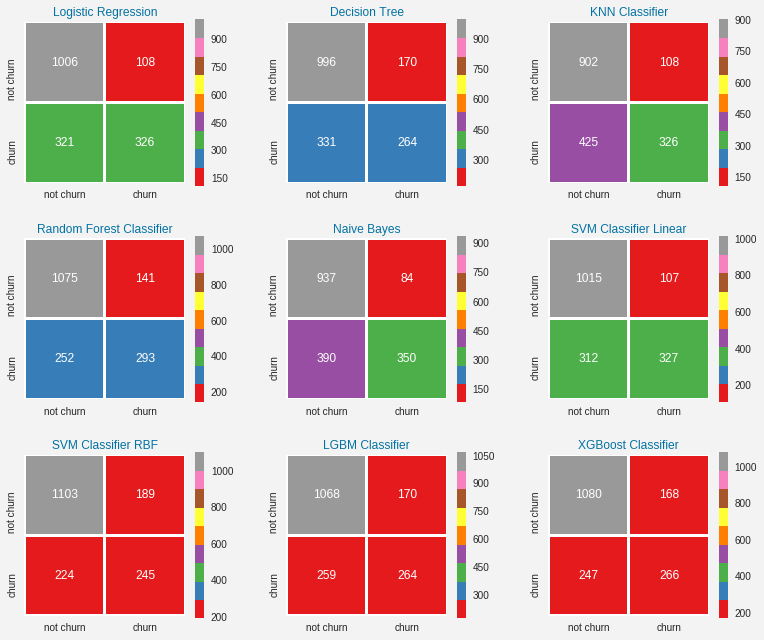

In [44]:
import matplotlib.pyplot as plt
import itertools

lst    = [logit,dt_classifier,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

fig = plt.figure(figsize=(13,15))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    plt.subplot(4,3,j+1)
    predictions = i.predict(test_X)
    conf_matrix = confusion_matrix(predictions,test_Y)
    sns.heatmap(conf_matrix,annot=True,fmt = "d",square = True,
                xticklabels=["not churn","churn"],
                yticklabels=["not churn","churn"],
                linewidths = 2,linecolor = "w",cmap = "Set1")
    plt.title(k,color = "b")
    plt.subplots_adjust(wspace = .3,hspace = .3)

### Compare ROC Curves matrices

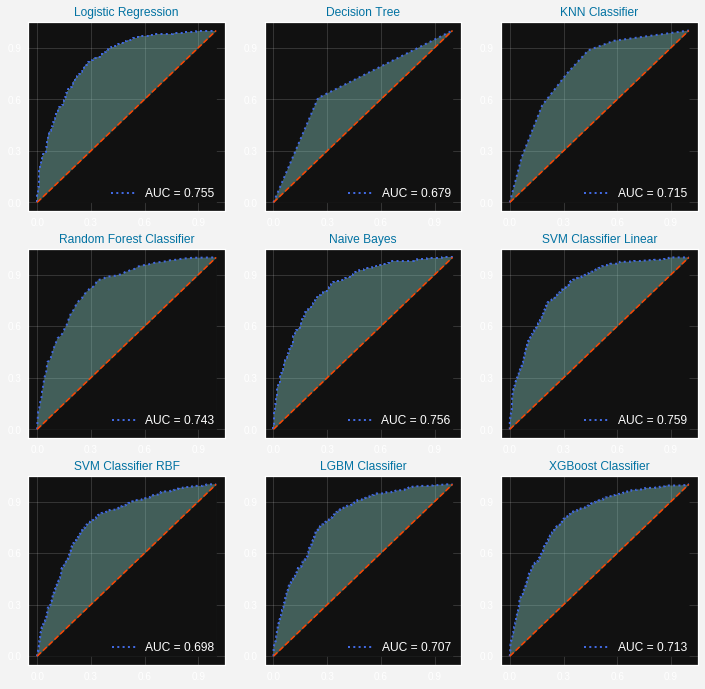

In [45]:
st    = [logit,dt_classifier,knn,rfc,
          gnb,svc_lin,svc_rbf,lgbm_c,xgc]

length = len(lst)

mods   = ['Logistic Regression',
          'Decision Tree','KNN Classifier','Random Forest Classifier',"Naive Bayes",
          'SVM Classifier Linear','SVM Classifier RBF', 'LGBM Classifier',
          'XGBoost Classifier']

plt.style.use("dark_background")
fig = plt.figure(figsize=(12,16))
fig.set_facecolor("#F3F3F3")
for i,j,k in itertools.zip_longest(lst,range(length),mods) :
    qx = plt.subplot(4,3,j+1)
    probabilities = i.predict_proba(test_X)
    predictions   = i.predict(test_X)
    fpr,tpr,thresholds = roc_curve(test_Y,probabilities[:,1])
    plt.plot(fpr,tpr,linestyle = "dotted",
             color = "royalblue",linewidth = 2,
             label = "AUC = " + str(np.around(roc_auc_score(test_Y,predictions),3)))
    plt.plot([0,1],[0,1],linestyle = "dashed",
             color = "orangered",linewidth = 1.5)
    plt.fill_between(fpr,tpr,alpha = .4)
    plt.fill_between([0,1],[0,1],color = "k")
    plt.legend(loc = "lower right",
               prop = {"size" : 12})
    qx.set_facecolor("k")
    plt.grid(True,alpha = .15)
    plt.title(k,color = "b")
    plt.xticks(np.arange(0,1,.3))
    plt.yticks(np.arange(0,1,.3))

### Conclusions and next steps

* It would be interesting to try without using SMOTE
* Once we figure out which algorithm seems to work best, we could try using GridSearch to find the best parameters
* We could use k fold cross validation for a more robust solution